In [165]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

%matplotlib inline
sns.set_theme(style='whitegrid', palette='deep')

<span style="color:green;font-weight:bold;font-size:20px"> 
Import sets 
</span>

In [166]:
train = pd.read_csv('house-pricing-data/train.csv')
test = pd.read_csv('house-pricing-data/test.csv')
submission = pd.read_csv('house-pricing-data/sample_submission.csv')

train = pd.concat([train, test])
print(train.shape)
train.head()

(2919, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


<span style="color:green;font-weight:bold;font-size:20px"> 
Defining useful functions
</span>

In [188]:
# create a few functions for quick use
def see_na(df: pd.DataFrame) -> None:
    """
    Function that shows all the NaN values count for each columns in a DataFrame.
    """
    
    nulls = df.isna().sum()
    nulls = nulls[nulls>0]
    print(len(nulls), "null columns\n", nulls)

def pattern_check(df: pd.DataFrame, rgx: str) -> pd.DataFrame:
    """
    Function works by using pattern regex 'rgx' parameter to look for columns 
    that fit that pattern
    """
    
    return df.filter(regex=rgx)

def rename_cols(df: pd.DataFrame, cols: list, cols_newname: list) -> pd.DataFrame:
    """
    Function that renames columns in a DataFrame, both column parameters
    need to have the same length, and the order of the names must be the same.
    """
    
    for i, j in zip(cols, cols_newname):
        df.rename(columns={i: j}, inplace=True)
    return df
    

def _plt(plt_type: str, df_slice: pd.DataFrame, 
         x_val: str=None, y_val: str=None, hue_val: str = None, 
         est: str='mean', X:int=10, Y:int=8, rot: int=30) -> None:
    """ Create a plot depending on the plt_type variable 
        plt_type: ['heat', 'scatter', 'line', 'box', 'bar', 'hist', 'reg']
        
            'heat' will create a heatmap, 'scatter' will create a scatterplot, 
            'line' a lineplot, 'box' a boxplot, 'bar' a barplot, 
            'hist' a histogram, 'reg' a regplot

        df_slice: the DataFrame to which the plot will be based

        x_val: feature column for the x value
        y_val: target column for the y value

        hue_val: hue value from the DataFrame
    """
    plt_type = plt_type.lower()

        
    plt.figure(figsize=(X,Y))
    

    if hue_val == None and y_val != None:
        plot_title = f'{x_val}_{y_val}'
    elif hue_val != None and y_val == None:
        plot_title = f'{x_val}_{hue_val}'
    elif hue_val == None and y_val==None:
        plot_title = f'{x_val} plot'
    else:
        plot_title = f'{x_val}_{y_val}_{hue_val}'
    
    
    match plt_type:
        case 'heat':
            plot_title = 'Heatmap'
            sns.heatmap(
                data=df_slice, 
                annot=True, 
                cmap='Purples', 
                center=0, 
                fmt='.2f', 
                linewidths=0.5)
        case 'scatter':
            sns.scatterplot(
                data=df_slice, 
                x=x_val, 
                y=y_val, 
                hue=hue_val)
        case 'line':
            sns.lineplot(
                data=df_slice, 
                x=x_val, 
                y=y_val, 
                hue=hue_val, 
                marker='o')
        case 'box':
            sns.boxplot(
                data=df_slice, 
                x=x_val, 
                y=y_val, 
                hue=hue_val)
        case 'bar':
            sns.barplot(
                data=df_slice,
                x=x_val, 
                y=y_val, 
                hue=hue_val, 
                palette='Paired',
                errorbar=None,
                estimator=est)
        case 'hist':
            sns.histplot(
                data=df_slice, 
                x=x_val, 
                hue=hue_val, 
                kde=True)
        case 'reg':
            sns.regplot(
                data=df_slice, 
                x=x_val, 
                y=y_val, 
                scatter_kws={'alpha': 0.5},
                line_kws=dict(color="r"),
                ci=99, 
                marker="x", 
                color=".3", 
                order=2)
        case _:
            raise ValueError(f"Unknown plot type: {plt_type}. "
                           f"Available: scatter, line, box, bar, hist, reg")
    
    plt.title(plot_title)
    plt.xticks(rotation=rot)
    
    if (hue_val!=None and plt_type not in ['reg']) and hue_val!=x_val:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    
    plt.savefig(f'imgs/{plot_title}.svg', format='svg')
    plt.show()

    

<span style='color:green;font-weight:bold;font-size:20px'>
Exploratory Data Analysis (EDA)
</span>

Check null values in numericals and categoricals

In [168]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [169]:
num_cols = (
    train
        .select_dtypes(include=np.number)
        .columns
        .drop(['Id'])
)
num_cols_wout_target = num_cols.drop(['SalePrice'])
train[num_cols].isnull().sum().sort_values(ascending=False).head()

SalePrice       1459
LotFrontage      486
GarageYrBlt      159
MasVnrArea        23
BsmtFullBath       2
dtype: int64

In [170]:
cat_df = (
    train
        .select_dtypes(include='object'))
cat_df.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
GarageCond       159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MSZoning           4
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
dtype: int64

Check Skewness

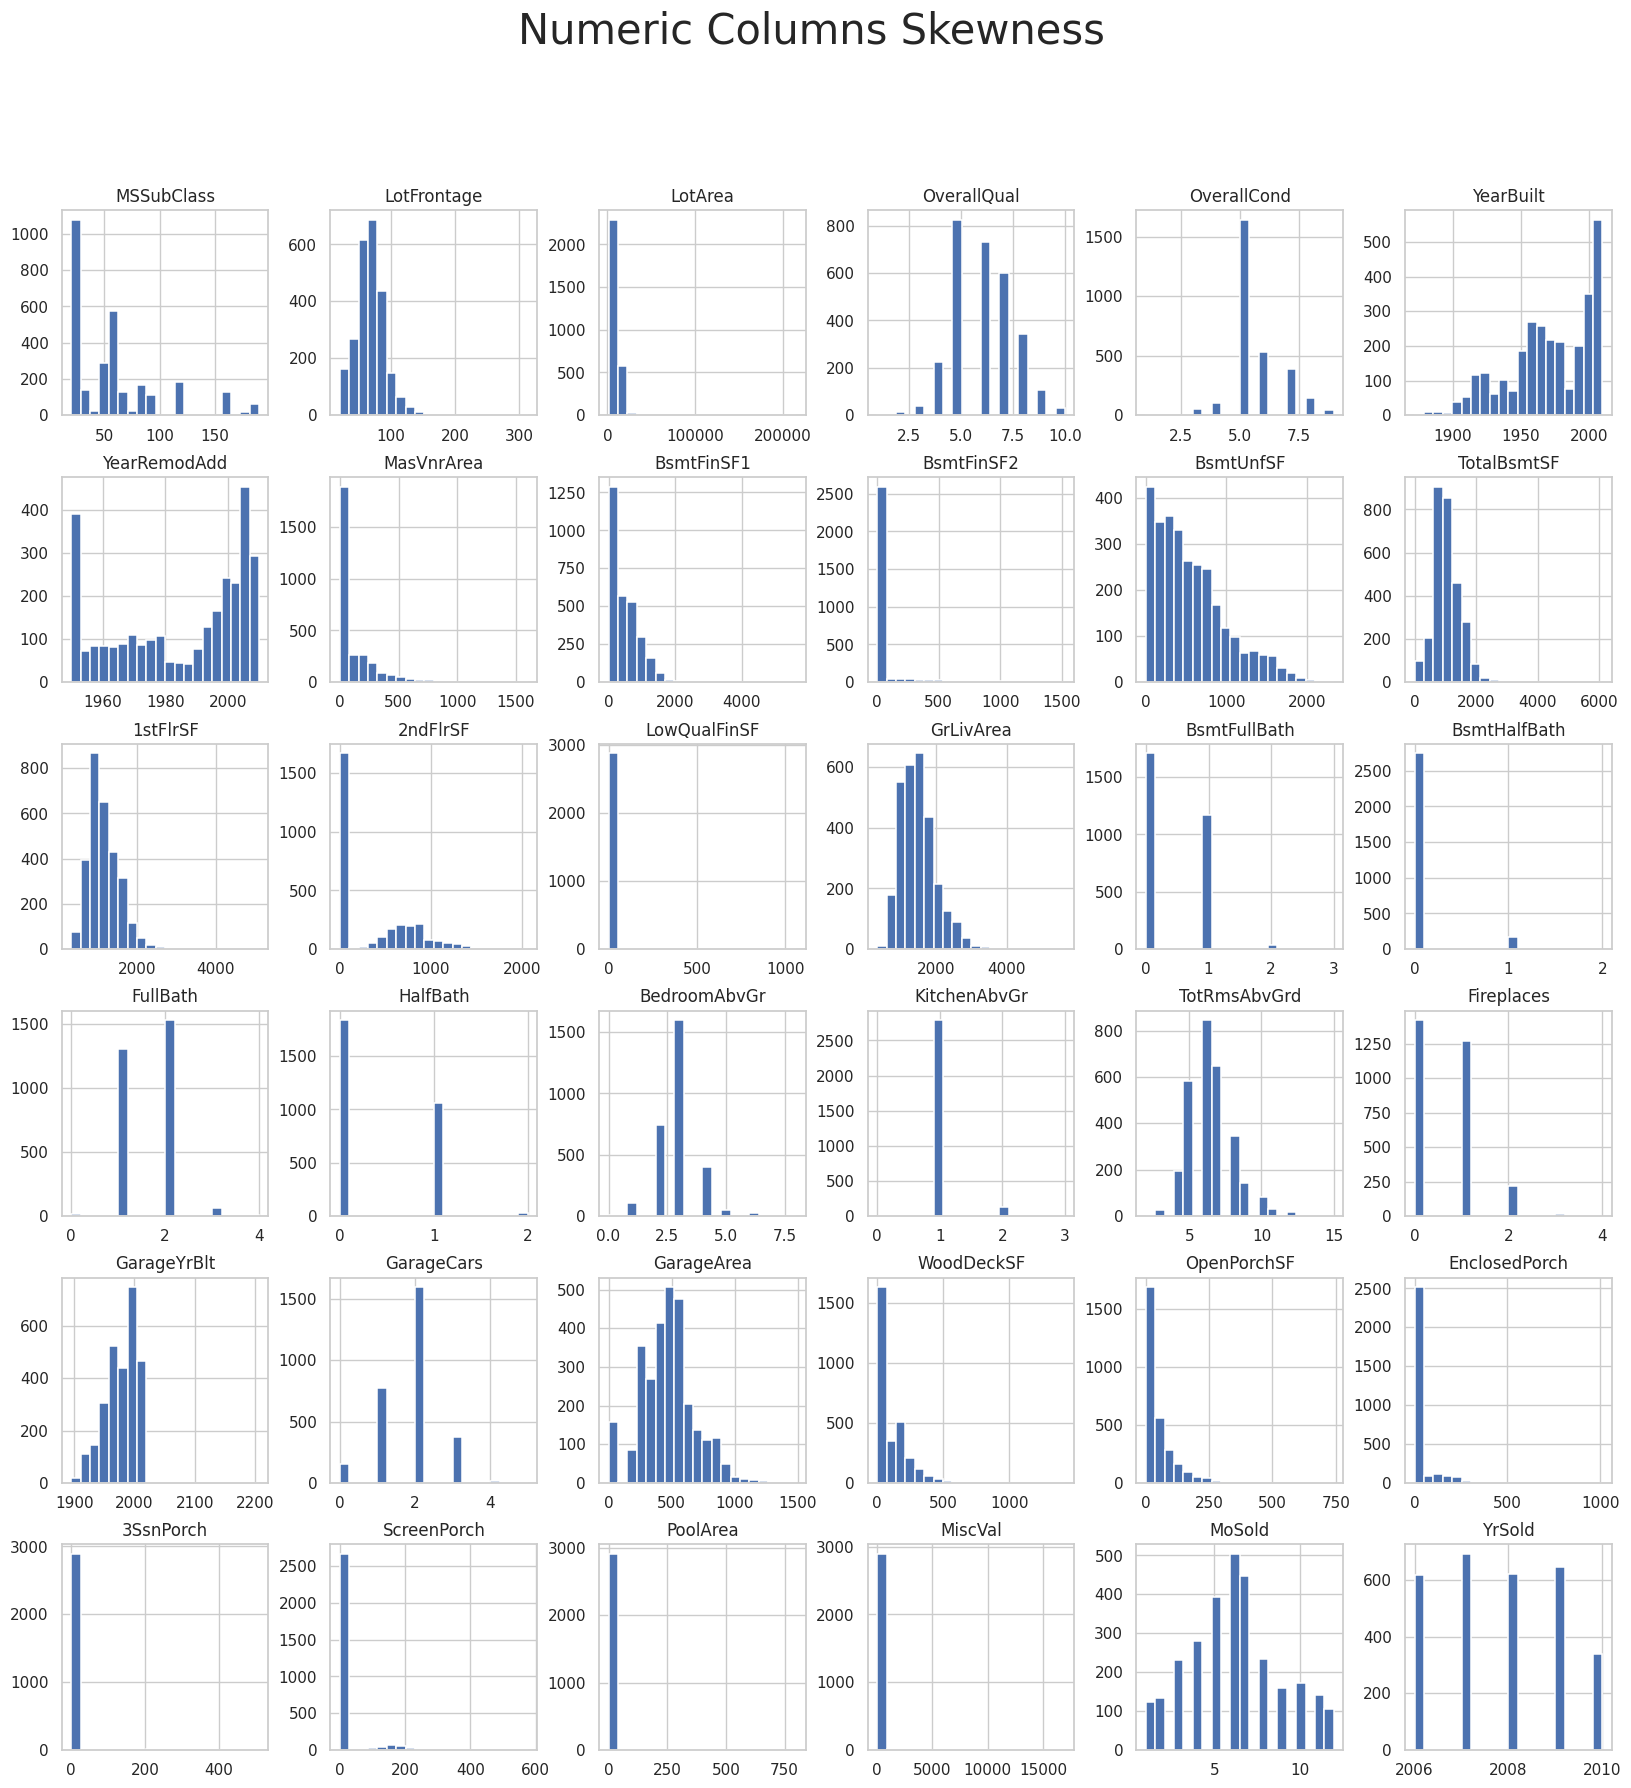

In [171]:
train[num_cols_wout_target].hist(bins=20, figsize=(20,20), linewidth=1.1)
plt.suptitle('Numeric Columns Skewness', fontsize=30)
plt.savefig('imgs/Histogram_nums.svg', format='svg')
plt.show()

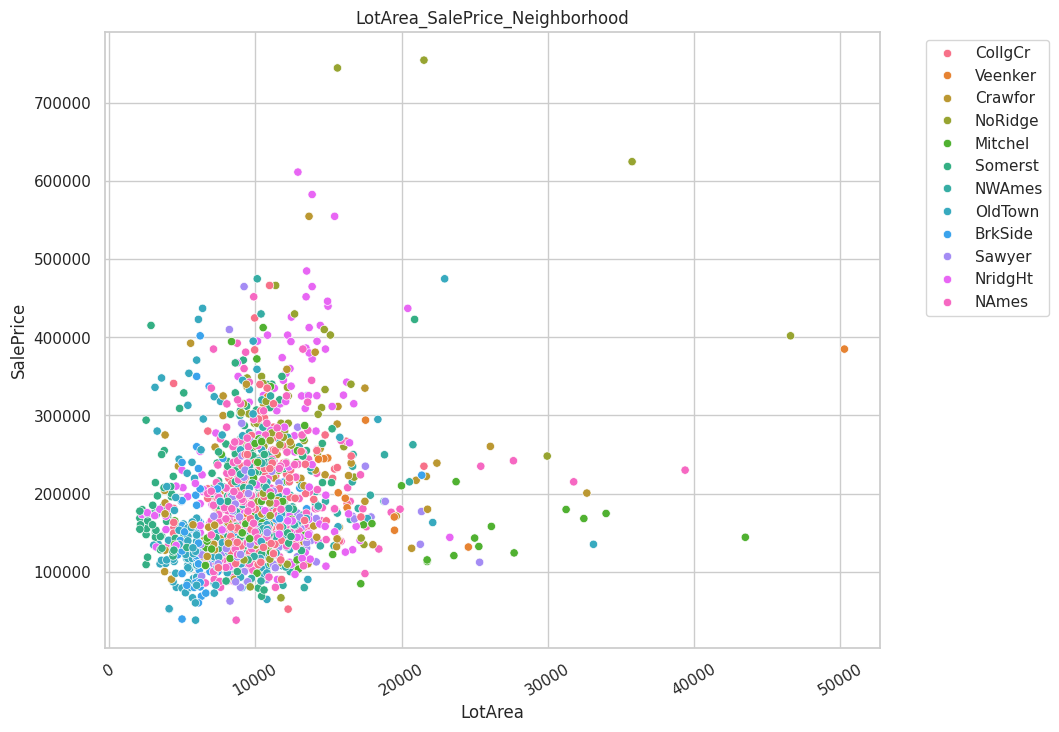

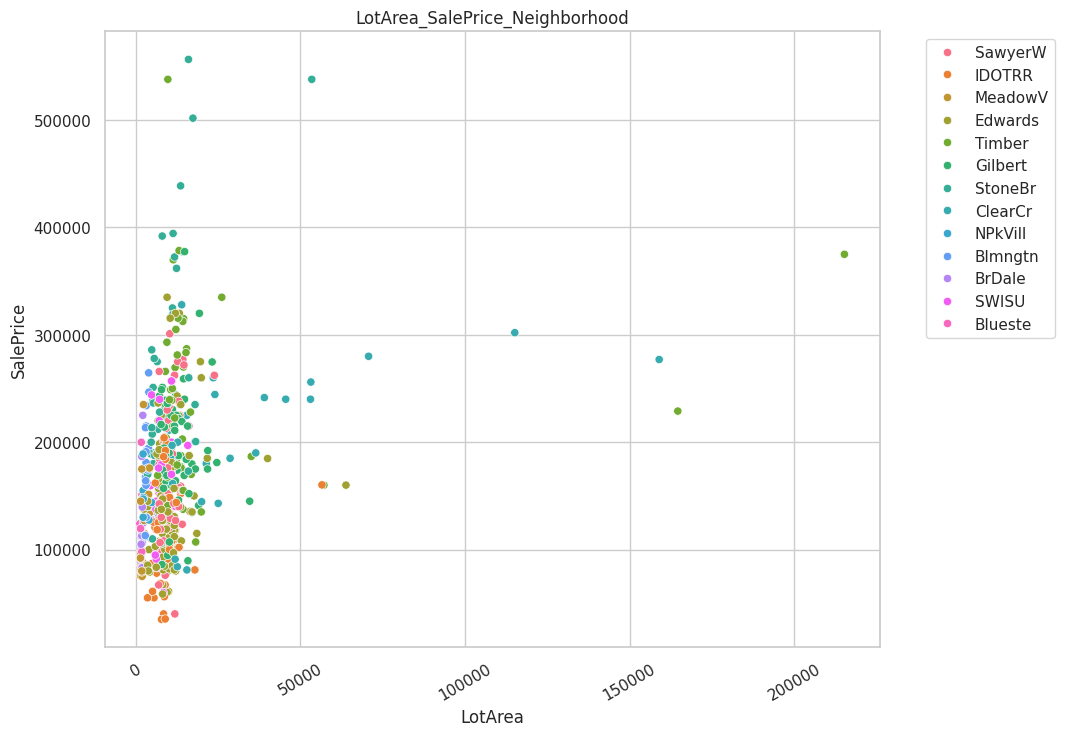

In [172]:
x_val = 'LotArea'
y_val = 'SalePrice'
hue_val = 'Neighborhood'

# get unique hue values
unique_hues = train[hue_val].unique()
midpoint = len(unique_hues) // 2

# separate the hue values
first_half_hues = unique_hues[:midpoint]
second_half_hues = unique_hues[midpoint:]

# filter dataframes
df_first = train[train[hue_val].isin(first_half_hues)]
df_second = train[train[hue_val].isin(second_half_hues)]

# Plot first half
_plt('scatter', df_first, x_val, y_val, hue_val)

# Plot second half
_plt('scatter', df_second, x_val, y_val, hue_val)

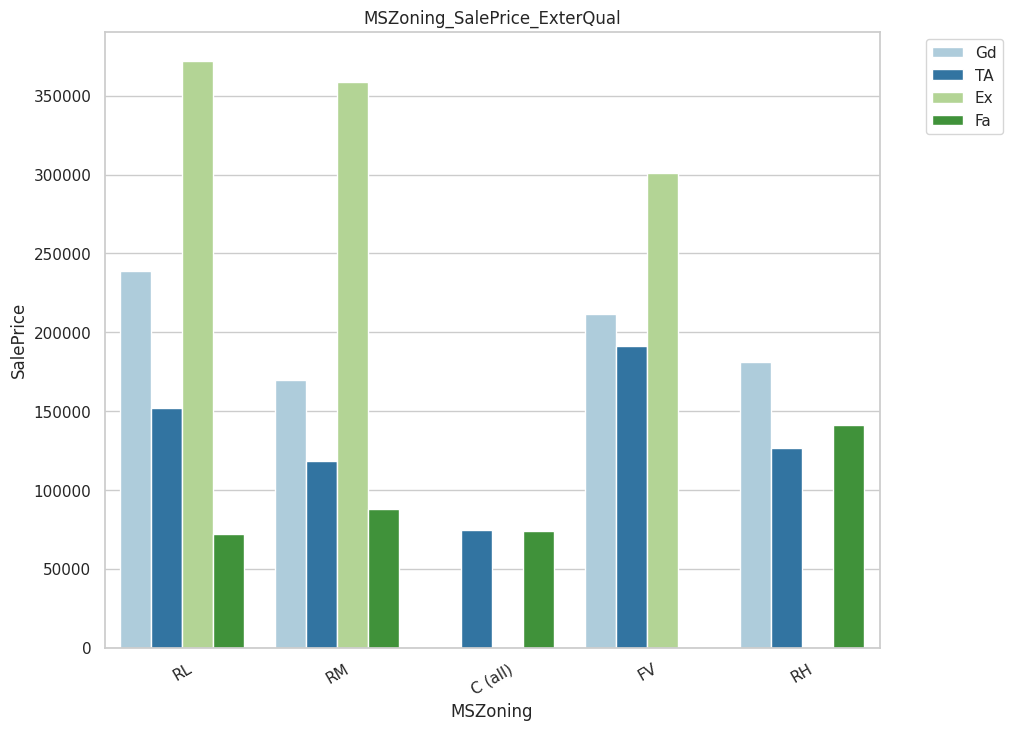

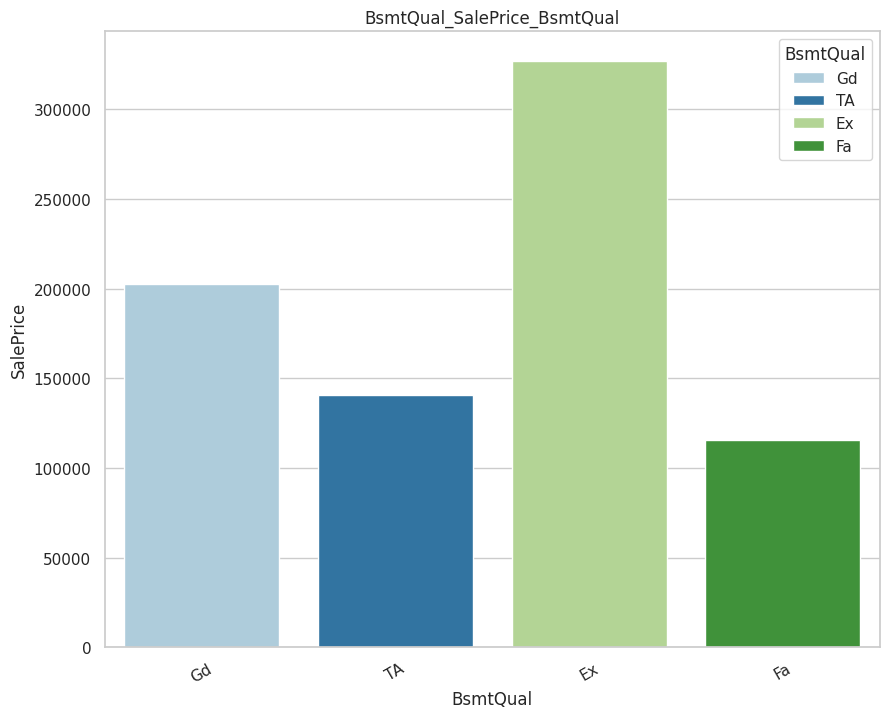

In [173]:
# sale prices group by MSZoning and binned by External Quality of property
_plt('bar', train.query('SalePrice.notnull()'), 'MSZoning', 'SalePrice', 'ExterQual')
_plt('bar', train.query('SalePrice.notnull()'), 'BsmtQual', 'SalePrice', 'BsmtQual')

In [174]:
train[num_cols_wout_target].skew()

MSSubClass        1.376165
LotFrontage       1.503278
LotArea          12.829025
OverallQual       0.197212
OverallCond       0.570605
YearBuilt        -0.600114
YearRemodAdd     -0.451252
MasVnrArea        2.602589
BsmtFinSF1        1.425722
BsmtFinSF2        4.147456
BsmtUnfSF         0.919824
TotalBsmtSF       1.162882
1stFlrSF          1.470360
2ndFlrSF          0.862118
LowQualFinSF     12.094977
GrLivArea         1.270010
BsmtFullBath      0.624062
BsmtHalfBath      3.932018
FullBath          0.167692
HalfBath          0.694924
BedroomAbvGr      0.326492
KitchenAbvGr      4.304467
TotRmsAbvGrd      0.758757
Fireplaces        0.733872
GarageYrBlt      -0.382150
GarageCars       -0.218373
GarageArea        0.241301
WoodDeckSF        1.843380
OpenPorchSF       2.536417
EnclosedPorch     4.005950
3SsnPorch        11.381914
ScreenPorch       3.948723
PoolArea         16.907017
MiscVal          21.958480
MoSold            0.195985
YrSold            0.132467
dtype: float64

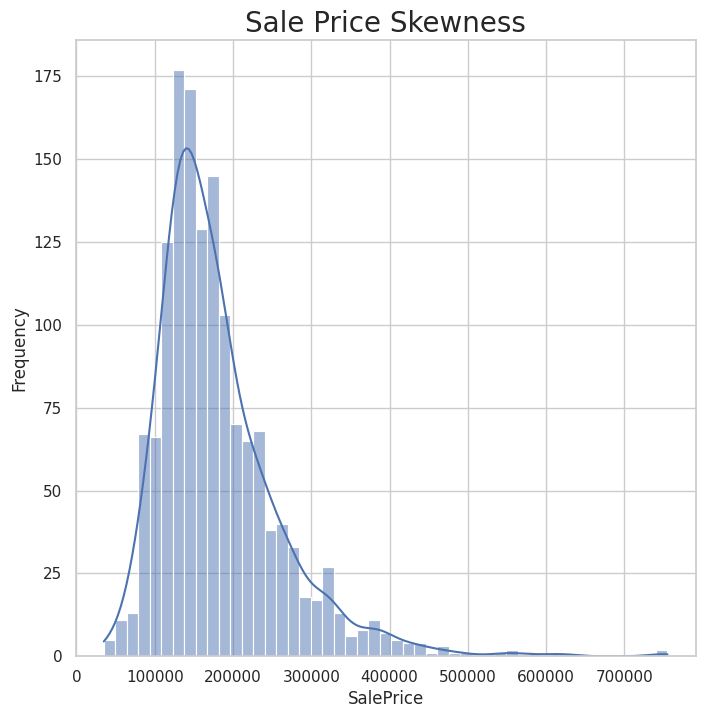

In [175]:
plt.figure(figsize=(8,8))
sns.histplot(train['SalePrice'], kde=True)
plt.title('Sale Price Skewness', fontsize=20)
plt.ylabel('Frequency')
plt.show()

In [176]:
print(train['SalePrice'].skew())

1.8828757597682129


SalePrice contains <span style='color:blue'> high right skewness</span>, we'll need to apply
a transformation to it.

<span style='color:Green;font-weight:bold;font-size:16px'>
Check the correlations of numerical features
</span>

In [177]:
correlations = (
        train[num_cols]
        .corr()
)

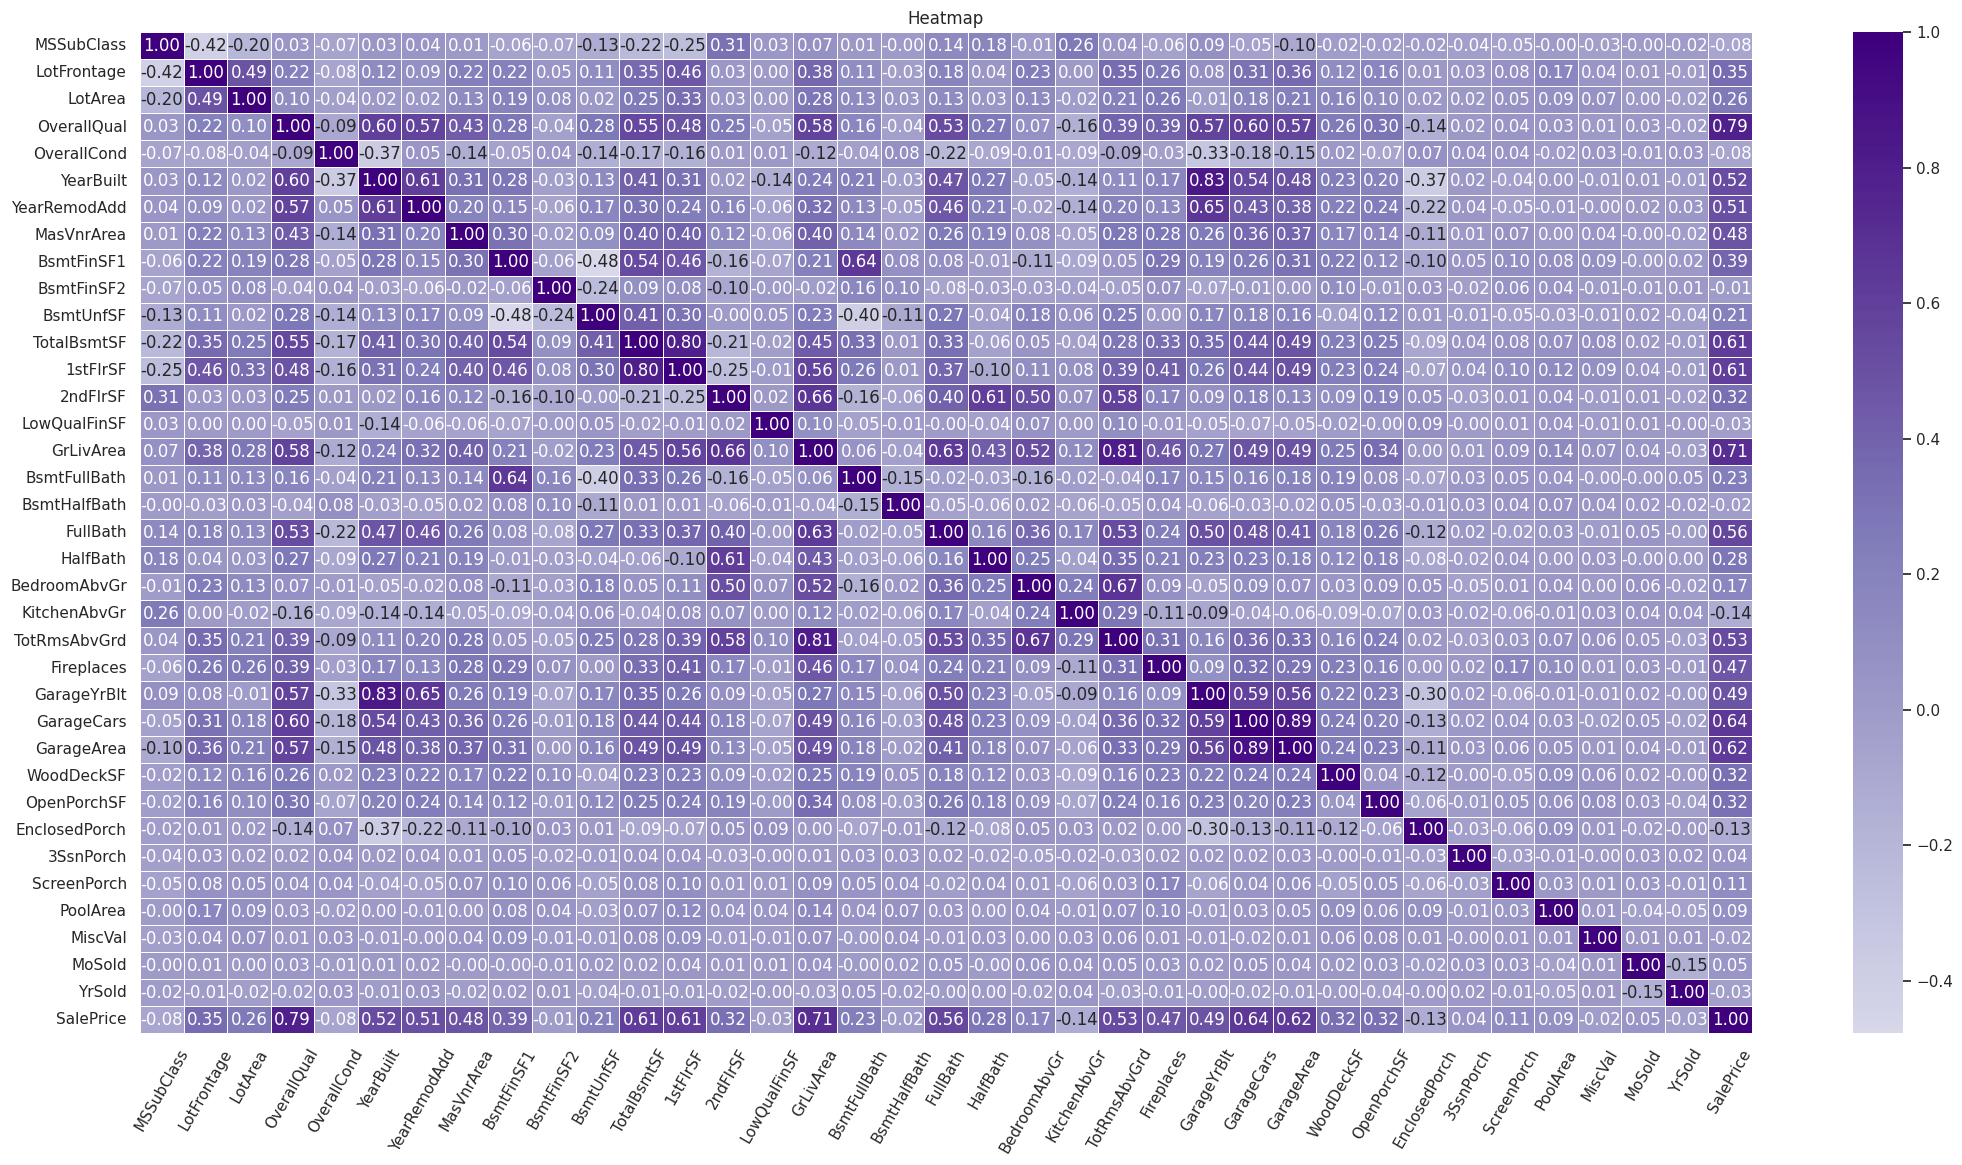

In [189]:
_plt('heat', correlations, X=26, Y=13, rot=60)

<span style='color:green;font-weight:bold;font-size:20px'>
Dealing with Null Values and Feature Engineering <br>
</span>
For numericals, we'll replace null values with 0, the mean or the mode.<br>
For categoricals, we'll replace null values with None, or with the mode.

In [179]:
null_percentages = (
        train
            .isnull()
            .sum()
            .sort_values(ascending=False)
            [train.isna().sum() > 0]/len(train))
null_percentages

PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
MasVnrType      0.605002
SalePrice       0.499829
FireplaceQu     0.486468
LotFrontage     0.166495
GarageCond      0.054471
GarageYrBlt     0.054471
GarageFinish    0.054471
GarageQual      0.054471
GarageType      0.053786
BsmtExposure    0.028092
BsmtCond        0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrArea      0.007879
MSZoning        0.001370
Functional      0.000685
BsmtFullBath    0.000685
Utilities       0.000685
BsmtHalfBath    0.000685
SaleType        0.000343
BsmtFinSF2      0.000343
BsmtFinSF1      0.000343
TotalBsmtSF     0.000343
BsmtUnfSF       0.000343
Exterior2nd     0.000343
KitchenQual     0.000343
GarageCars      0.000343
GarageArea      0.000343
Electrical      0.000343
Exterior1st     0.000343
dtype: float64

In [180]:
null_percentages[null_percentages > 0.8]

PoolQC         0.996574
MiscFeature    0.964029
Alley          0.932169
Fence          0.804385
dtype: float64

In [181]:
def _feature_eng(df: pd.DataFrame) -> pd.DataFrame:
    df_return = df.copy()
    
    cols_to_drop = ['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence']

    df_return = df_return.drop(columns=cols_to_drop)
    
    
    ## First, Binary encoding and new columns
    df_return = df_return.assign(
        **{
            'HouseAge': lambda x: x.YrSold - x.YearBuilt,
            'Remodeled': lambda x: np.where(x.YearBuilt != x.YearRemodAdd, 1, 0).astype(int),
            'HasBsmt': lambda x: np.where(x.TotalBsmtSF > 0, 1, 0).astype(int),
            'HasPool': lambda x: np.where(x.PoolArea > 0, 1, 0).astype(int),
            'HasGarage': lambda x: np.where(x.GarageArea > 0, 1, 0).astype(int),
            'HasFireplace': lambda x: np.where(x.Fireplaces > 0, 1, 0).astype(int),
            'Has2ndFloor': lambda x: np.where(x['2ndFlrSF'] > 0, 1, 0).astype(int),
            'TotalSF': lambda x: x['TotalBsmtSF'] + x['1stFlrSF'] + x['2ndFlrSF'],
            'TotalBathArea': lambda x: x.FullBath + x.BsmtFullBath + 0.5 * (x.BsmtHalfBath + x.HalfBath),
        }
    )

    # Second, Nominal and Ordinal Encoding
    # For Nominal i used get_dummies, and for ordinals i used OrdinalEncoder
    # with the specified orders
    encoding_feats = {'Nominal': ['MSSubClass', 'MSZoning', 'Street', 'Utilities', 'LotConfig', 'Neighborhood', 
                 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
                 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType',
                'SaleType', 'SaleCondition'], 
                  'Ordinal': ['LotShape', 'LandContour', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional',
               'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']}

    # Nominal
    df_return.MSSubClass = df_return.MSSubClass.astype(object)
    
    nominal_encoded = pd.get_dummies(df_return[encoding_feats['Nominal']], dtype=np.int32)
    df_return = pd.concat([df_return, nominal_encoded], axis=1)
    df_return = df_return.drop(df_return[encoding_feats['Nominal']].columns, axis=1)


    # Ordinal
    ordinal_feats_order = [
    ['Reg', 'IR1', 'IR2', 'IR3'],                   # LotShape
    ['Low', 'HLS', 'Bnk', 'Lvl'],                   # LandContour  
    ['Gtl', 'Mod', 'Sev'],                          # LandSlope
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                 # ExterQual
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                 # ExterCond
    ['Nb', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],           # BsmtQual
    ['Nb', 'Po', 'Fa', 'TA', 'Gd'],                 # BsmtCond
    ['Nb', 'No', 'Mn', 'Av', 'Gd'],                 # BsmtExposure
    ['Nb', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], # BsmtFinType1
    ['Nb', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], # BsmtFinType2
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                 # HeatingQC
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                 # KitchenQual
    ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], # Functional
    ['NoFi', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],         # FireplaceQu
    ['NoG', 'Unf', 'RFn', 'Fin'],                   # GarageFinish
    ['NoG', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],          # GarageQual
    ['NoG', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],          # GarageCond
    ['N', 'P', 'Y']                                # PavedDrive
    ]

    from sklearn.preprocessing import OrdinalEncoder
    ordinal_enc = OrdinalEncoder(categories=ordinal_feats_order, 
                                 handle_unknown='use_encoded_value', unknown_value=-1,
                                dtype=np.int32)
    
    encoded_ordinals = ordinal_enc.fit_transform(df_return[encoding_feats['Ordinal']])
    df_return[encoding_feats['Ordinal']] = encoded_ordinals

    # Checking
    print('original df shape, rows: ', df.shape[0], ', columns: ', df.shape[1])

    print('encoded df shape, rows: ', df_return.shape[0], ', columns: ', df_return.shape[1])

    return df_return



In [182]:
train_copy = _feature_eng(train)
train_copy.head()

original df shape, rows:  2919 , columns:  81
encoded df shape, rows:  2919 , columns:  236


,LotFrontage,LotArea,LotShape,LandContour,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,HouseAge,Remodeled,HasBsmt,HasPool,HasGarage,HasFireplace,Has2ndFloor,TotalSF,TotalBathArea,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,0,3,0,7,5,2003,2003,196.0,3,2,4,3,1,6,706.0,1,0.0,150.0,856.0,4,856,854,0,1710,1.0,0.0,2,1,3,1,3,8,6,0,-1,2003.0,2,2.0,548.0,3,3,2,0,61,0,0,0,0,0,2,2008,208500.0,5,0,1,0,1,0,1,2566.0,3.5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,

Some new Plots with the new columns:

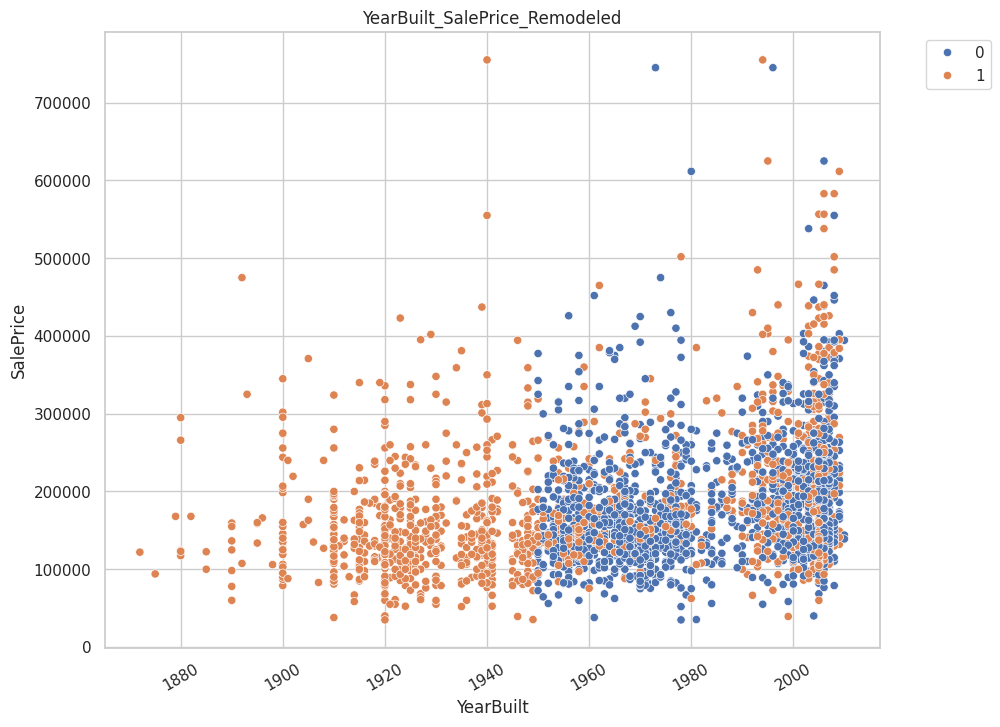

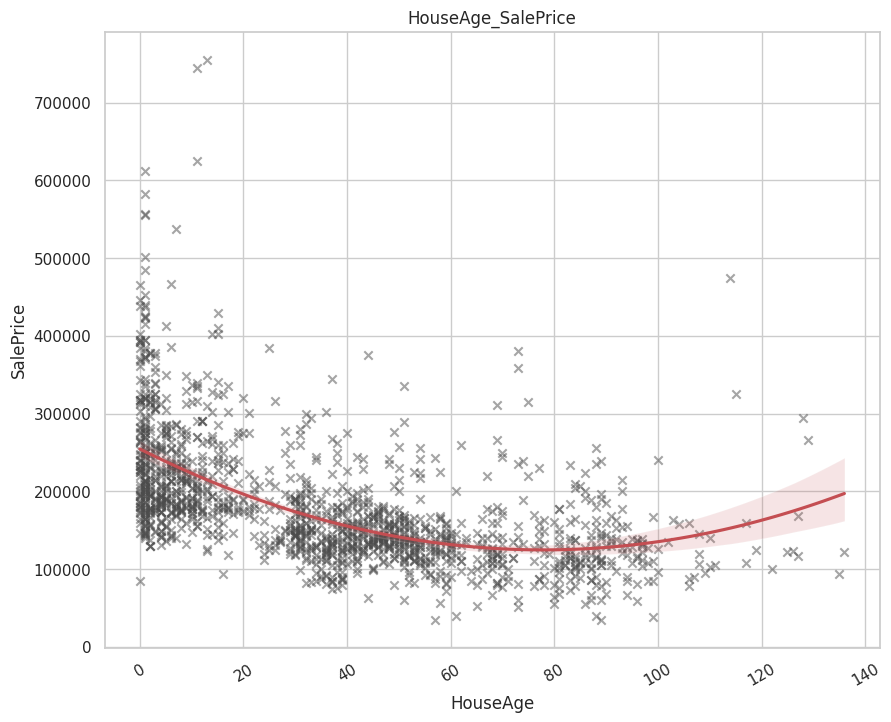

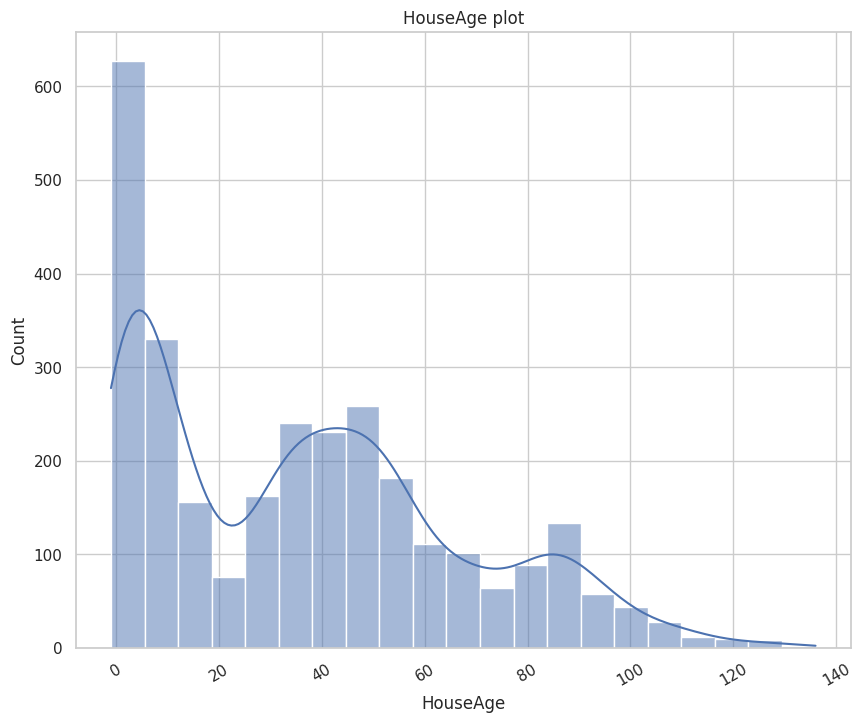

In [183]:
# sale prices by year ; sale prices by year and if they had remodelling done
_plt(plt_type='scatter', df_slice=train_copy, x_val='YearBuilt', y_val='SalePrice', 
     hue_val='Remodeled')
_plt(plt_type='reg', df_slice=train_copy, x_val='HouseAge', y_val='SalePrice')
_plt('hist', train_copy, 'HouseAge')



There are a bunch of plots we can do but for now we'll keep it to this.

---

Let's save the train_copy dataframe to a csv

In [184]:
train_copy.to_csv("house-pricing-data/train_copy.csv", index=False)

In [185]:
df = pd.read_csv("house-pricing-data/train_copy.csv")